**Версии библиотек:**

- pandas 2.1.4
- numpy 1.26.4
- statsmodels 0.14.0
- seaborn 0.13.2
- matplotlib 3.8.0
- scikit-learn 1.2.2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import statsmodels as sm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white

import random

RANDOM_STATE = 42

In [4]:
def metrics_report(y_true, y_pred):
    print(f'R2 score: {r2_score(y_true, y_pred)}')
    print(f'RMSE: {mean_squared_error(y_true, y_pred)**0.5}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')

#### Задание 1


Линейная регрессия позволяет проверить гипотезу об отличии коэффициента от нуля.

Пусть имеется набор данных о стоимости какого-то товара. В таблице две колонки: значение некоторой характеристики товара и его стоимость в рублях. Постройте линейную регрессию из sklearn и statsmodels и выберите все верные ответы.

In [7]:
# Загрузите данные из файла task0.csv и выведите первые 5 строк на экран
df = pd.read_csv(r"C:\Users\79817\Jupiter Notebooks\ODS Classical models\HW1\task0.csv")
df.drop(axis=1, columns= ['Unnamed: 0'], inplace= True)
df.head(10)

,feature,cost
0,18.189092,12169
1,4.862900,19431
2,5.874894,10816
3,99.297459,7779
4,59.958159,19862
5,31.963386,5478
6,92.755977,10489
7,68.752276,6087
8,51.911842,1776
9,33.698596,8713


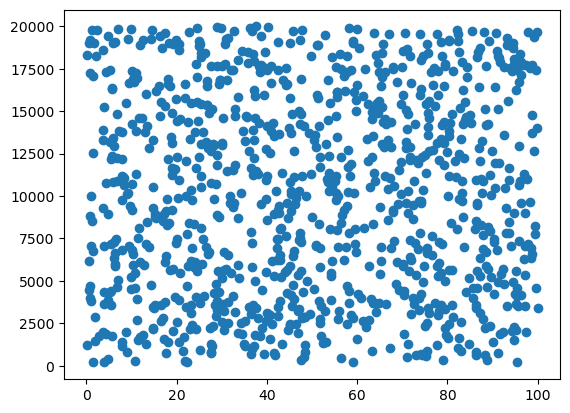

In [8]:
# Постройте scatterplot
plt.scatter(
    x=df['feature'],
    y=df['cost']
)
plt.show()

In [9]:
max_feat = df['feature'].max()
max_cost = df['cost'].max()

df['feature'] = df['feature']/max_feat
df['cost'] = df['cost']/max_cost

In [10]:
df.head()

,feature,cost
0,0.181953,0.608724
1,0.048646,0.971987
2,0.058769,0.541043
3,0.993314,0.389125
4,0.599786,0.993547


In [11]:
# Постройте модель линейной регрессии из sklearn, обучите ее на всем датафрейме и выведите на экран коэффициенты
lin_reg = LinearRegression()

lin_reg.fit(X=df['feature'].values.reshape(-1, 1), y=df['cost'].values.reshape(-1, 1))

print(lin_reg.coef_)
# ваш код здесь

[[0.03033251]]


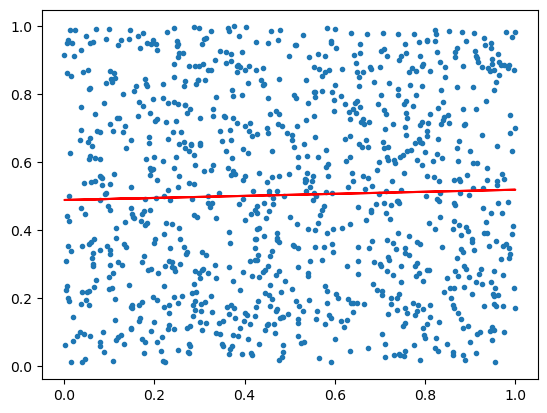

In [12]:
# График предсказаний регрессии
plt.scatter(x=df['feature'], y=df['cost'], marker='.')
plt.plot(df['feature'], lin_reg.predict(df[['feature']]), color='r')
plt.show()

In [13]:
# Теперь постройте регрессию из statsmodels. Но прежде чем это сделать, необходимо добавить в выборку константу с помощью функции sm.add_constant().
# Это необходимое техническое действие, без которого предсказания модели будут некорректными

X_sm = sm.add_constant(df['feature'])

In [14]:
# Постройте и обучите модель. Выведите результаты обучения (summary). После этого заполните ответ в гугл-форме.

ols_model = sm.OLS(df['cost'], X_sm)
ols_res = ols_model.fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8924
Date:                Sat, 21 Sep 2024   Prob (F-statistic):              0.345
Time:                        19:46:50   Log-Likelihood:                -182.45
No. Observations:                1000   AIC:                             368.9
Df Residuals:                     998   BIC:                             378.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4885      0.019     26.345      0.0

#### Задание 2


Проверим предположение о необходимости репрезентативности выборки. Например, ограничим данные и сравним качество прогноза на полной и ограниченной выборках.

Пусть имеется набор данных о продажах домов. Рассмотрим две выборки, обучим на них модель линейной регрессии и сравним результаты. Первая выборка должна включать в себя только данные о домах, в которых не более 2 спальных комнат. Вторая выборка будет включать в себя все типы домов. Построить регрессию из statsmodels и в качестве ответа предоставить значения коэффициентов детерминации в обоих случаях (округлить до 3 знака)

Формат ответа: 0.333 0.342

In [17]:
# Считайте данные из файла house_prices.csv и выведите первые 5 строк на экран
data = pd.read_csv(r'C:\Users\79817\Jupiter Notebooks\ODS Classical models\HW1\house_prices.csv')
data.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


In [18]:
data.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [19]:
# Создайте списки категориальных и количественных переменных (целевую переменную в списки не включать)
var_categorical = ['mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning','prefarea', 'furnishingstatus']
var_numeric = ['area', 'bedrooms', 'bathrooms', 'stories',
       'parking']

In [20]:
# Сделайте две выборки, описанные в задании
X1 = data[data['bedrooms'] < 3]
X2 = data
y1 = X1['price']
y2 = X2['price']

In [21]:
# Закодируйте категориальные признаки (там, где значения 'yes'/'no', просто замените из на 1/0, остальное - с помощью OneHotEncoder())
YN_cols = ['mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning','prefarea']

data[YN_cols] = data[YN_cols].replace({'yes' : 1 , 'no' : 0})
X1[YN_cols] = X1[YN_cols].replace({'yes' : 1 , 'no' : 0})
X2[YN_cols] = X2[YN_cols].replace({'yes' : 1 , 'no' : 0})
# ваш код здесь (кодировка бинарных признаков)

In [22]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [23]:
# Кодировка остальных категориальных признаков
encoder1 = OneHotEncoder(handle_unknown='ignore')

furnished_enc_1 = pd.DataFrame(
    encoder1.fit_transform(X1[['furnishingstatus']]).toarray(),
    columns=encoder1.categories_
)

encoder2 = OneHotEncoder(handle_unknown='ignore')

furnished_enc_2 = pd.DataFrame(
    encoder2.fit_transform(X2[['furnishingstatus']]).toarray(),
    columns=encoder2.categories_
)

In [24]:
# Теперь масштабируйте количественные признаки
scaler1 = StandardScaler()

X1_numeric = pd.DataFrame(
    scaler1.fit_transform(X1[var_numeric]),
    columns=var_numeric
)

scaler2 = StandardScaler()

X2_numeric = pd.DataFrame(
    scaler2.fit_transform(X2[var_numeric]),
    columns=var_numeric
)

In [25]:
# Соберите все в один датафрейм
X1_enc = X1_numeric.join([furnished_enc_1, X1[var_categorical].reset_index(drop=True)]).drop('furnishingstatus', axis=1)
X1_enc.shape

(138, 14)

In [26]:
X2_enc = X2_numeric.join([furnished_enc_2, X2[var_categorical].reset_index(drop=True)]).drop('furnishingstatus', axis=1)

In [27]:
# Для удобства переименуйте колонки, получившиеся при кодировании признака 'furnishingstatus' и удалите одну лишнюю ('unfurnished')
              
X1_enc = X1_enc.drop(axis = 1, columns = [('unfurnished',)]) 

X2_enc = X2_enc.drop(axis = 1, columns = [('unfurnished',)]) 

In [28]:
X1_enc.rename(columns={('semi-furnished',) : 'sem', ('furnished',) : 'furnished'},inplace=True)
X2_enc.rename(columns={('semi-furnished',) : 'sem', ('furnished',) : 'furnished'},inplace=True)

X1_enc

,area,bedrooms,bathrooms,stories,parking,furnished,sem,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
0,2.215891,0.121268,-0.248069,-0.390279,0.719969,0.0,1.0,1,0,0,0,1,0
1,4.464476,0.121268,-0.248069,-0.390279,0.719969,1.0,0.0,1,0,1,1,0,0
2,1.029138,0.121268,4.031129,6.634747,-0.679407,1.0,0.0,1,0,1,0,0,1
3,1.107214,0.121268,-0.248069,-0.390279,2.119344,1.0,0.0,1,1,1,0,0,1
4,1.133239,0.121268,-0.248069,-0.390279,2.119344,1.0,0.0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,-0.657301,0.121268,-0.248069,-0.390279,0.719969,0.0,0.0,1,0,0,0,0,0
134,-0.506875,0.121268,-0.248069,-0.390279,-0.679407,0.0,0.0,1,0,0,0,0,0
135,-0.849888,0.121268,-0.248069,-0.390279,0.719969,0.0,0.0,0,0,0,0,0,0
136,-0.844683,0.121268,-0.248069,-0.390279,2.119344,0.0,0.0,1,0,1,0,0,0


In [29]:
# К обеим выборкам добавьте константу для работы с моделями из statsmodels, затем выполните сброс индексов в обеих сериях целевой переменной

X1_enc_ols = sm.add_constant(X1_enc)

X2_enc_ols = sm.add_constant(X2_enc)
# ваш код здесь


y1.reset_index(drop=True, inplace=True)
y2.reset_index(drop=True, inplace=True)

In [30]:
# Постройте модели, обучите их на соответствующих выборках и выведите информацию о моделях
ols1 = sm.OLS(y1, X1_enc_ols)
ols1_res = ols1.fit()
print(ols1_res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     17.69
Date:                Sat, 21 Sep 2024   Prob (F-statistic):           1.83e-22
Time:                        19:46:50   Log-Likelihood:                -2030.0
No. Observations:                 138   AIC:                             4088.
Df Residuals:                     124   BIC:                             4129.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.877e+06   1.59e+05     

In [31]:
ols2 = sm.OLS(y2, X2_enc_ols)
ols2_res = ols2.fit()
print(ols2_res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     87.52
Date:                Sat, 21 Sep 2024   Prob (F-statistic):          9.07e-123
Time:                        19:46:50   Log-Likelihood:                -8331.5
No. Observations:                 545   AIC:                         1.669e+04
Df Residuals:                     531   BIC:                         1.675e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.506e+06   1.46e+05     

In [32]:
X2_enc_ols.shape

(545, 14)

In [33]:
y2.shape

(545,)

In [34]:
ols1.predict(X2_enc_ols.T).shape

(138, 545)

In [35]:
ols1.predict(X1_enc_ols.T).shape

(138, 138)

In [36]:
# Введите ответ в гугл-форме

#### Задание 3

Еще одно предположение, выполнение которого сильно влияет на результат работы линейной регрессии, - это предположение о строгой экзогенности. Суть заключается в следующем. Предположим, было составлено уравнение регрессии, в котором целевой признак `'y'` определяется признаком `'x'` и некоторой константой. Предположим также, что существует некоторый фактор `'t'`, который влияет и на `'x'`, и на `'y'`, однако в уравнении не присутствует. Это может быть какой-то невидимый нам, неявный фактор. Получается, что наше уравнение является неполным, не описывает картину в целом.

Пусть имеется набор данных из трех колонок: два признака (`'x'` и `'t'`) и таргет `'y'`. Необходимо (а) построить регрессию, используя только `'x'` и `'y'`; (б) построить регрессию на `'t'` и `'y'`. В качестве ответа выбрать верные значения коэффициентов детерминации

In [39]:
# Создание нормально распределенного шума
rng = np.random.RandomState(RANDOM_STATE)
mu, sigma = 0, 0.1
eps = rng.normal(mu, sigma, size=1000)

In [40]:
c_train = 0
c_test = 0.1

In [41]:
# Создание набора данных
t = np.linspace(0, 1, 1000)

y = np.log(1 + t)
x = t + eps

df = pd.DataFrame({'t' : t, 'x' : x, 'y' : y})
df.head()

,t,x,y
0,0.000000,0.049671,0.000000
1,0.001001,-0.012825,0.001001
2,0.002002,0.066771,0.002000
3,0.003003,0.155306,0.002999
4,0.004004,-0.019411,0.003996


In [42]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df[['x', 't']], df['y'], test_size=0.4, shuffle=True, random_state=RANDOM_STATE)

X_train['x'] += c_train
X_test['x'] += c_test

In [43]:
X_test.head()

,x,t
521,0.675858,0.521522
737,0.936007,0.737738
740,0.656653,0.740741
660,0.703294,0.660661
411,0.398947,0.411411


In [44]:
# Постройте модель только на 'x' и 'y', посчитайте коэффициент детерминации на тестовой выборке
model = sm.OLS(y_test, sm.add_constant(X_test['x']))

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     3094.
Date:                Sat, 21 Sep 2024   Prob (F-statistic):          8.63e-190
Time:                        19:46:52   Log-Likelihood:                 514.34
No. Observations:                 400   AIC:                            -1025.
Df Residuals:                     398   BIC:                            -1017.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.007      1.341      0.1

In [45]:
# Постройте модель только на 't' и 'y', посчитайте коэффициент детерминации на тестовой выборке и сдайте ответ в гугл-форму
model = sm.OLS(y_test, sm.add_constant(X_test['t']))

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 4.862e+04
Date:                Sat, 21 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:46:52   Log-Likelihood:                 1042.7
No. Observations:                 400   AIC:                            -2081.
Df Residuals:                     398   BIC:                            -2073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0451      0.002     25.681      0.0

Отсюда можно сделать вывод о том, что для корректной работы модели важно правильно выбрать признаки.

#### Задание 4

Вернемся к данным о продаже домов. Постройте матрицу корреляций числовых признаков для тренировочной выборки. Закодируйте категориальные и масштабируйте количественные. После этого постройте регрессию из statsmodels и, проанализировав ее выдачу, определите признаки, не являющиеся полезными для построения модели. В качестве ответа на вопрос введите значение коэффициента корреляции Пирсона между признаками 'bedrooms' и 'stories', а также признаки, которые не являются полезными для модели и p-value для них (все выводится через пробел, десятичный разделитель - точка)

<u>Формат ответа:</u> corr_coef feature feature_p_value

<u>Пример:</u> 0.001 mainroad 0.123

In [49]:
# Снова считайте данные из файла house_prices.csv
data = pd.read_csv(r'C:\Users\79817\Jupiter Notebooks\ODS Classical models\HW1\house_prices.csv')
data.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


In [50]:
# Создайте списки категориальных и количественных переменных (целевую переменную в списки не включать)
var_categorical = ['mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning','prefarea', 'furnishingstatus']
var_numeric = ['area', 'bedrooms', 'bathrooms', 'stories',
       'parking']

In [51]:
# Разделите данные на тренировочную и тестовую выборки. ВАЖНО: здесь и везде далее, где это возможно, указывать параметр random_state=RANDOM_STATE.
# Размер тестовой выборки 0.4, перемешивание данных должно быть включено (параметр shuffle)
X_train, X_test, y_train, y_test = train_test_split(X2_enc, y2, test_size=0.4, shuffle=True, random_state=RANDOM_STATE)

               area  bedrooms  bathrooms   stories   parking
area       1.000000  0.151858   0.193820  0.083996  0.352980
bedrooms   0.151858  1.000000   0.373930  0.408564  0.139270
bathrooms  0.193820  0.373930   1.000000  0.326165  0.177496
stories    0.083996  0.408564   0.326165  1.000000  0.045547
parking    0.352980  0.139270   0.177496  0.045547  1.000000


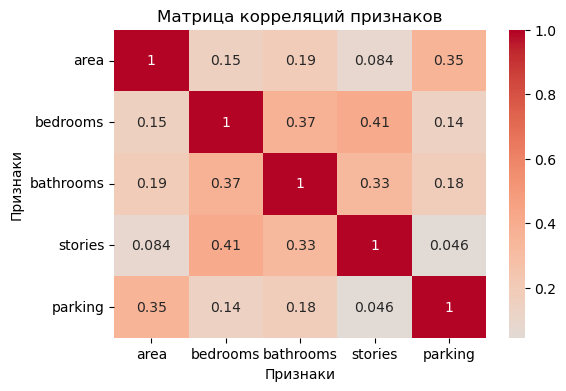

In [52]:
# Построить матрицу корреляций
corr_matrix = data[var_numeric].corr()

print(corr_matrix) 

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True)
plt.title('Матрица корреляций признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

In [53]:
# Выполните кодирование категориальных и масштабирование количественных признаков (аналогично заданию 2).
# После этого соберите все в один датафрейм, переименуйте и удалите нужные колонки и сбросьте индексы в сериях целевой переменной

# ваш код здесь

X_train.head()

,area,bedrooms,bathrooms,stories,parking,furnished,sem,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
519,-0.143229,-1.308863,-0.570187,0.224410,-0.805741,0.0,0.0,1,0,0,0,0,0
118,0.585503,0.047278,-0.570187,-0.929397,-0.805741,1.0,0.0,1,0,1,0,1,1
407,-1.386224,0.047278,-0.570187,1.378217,-0.805741,1.0,0.0,1,0,0,0,0,1
114,0.760768,-1.308863,-0.570187,-0.929397,1.517692,1.0,0.0,1,1,1,0,0,0
515,-0.895022,0.047278,-0.570187,0.224410,-0.805741,0.0,0.0,1,0,1,0,0,0


In [54]:
# Добавьте константы
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [55]:
# Постройте модель линейной регрессии из statsmodels и, проанализировав ее выдачу,
# найдите признаки, не являющиеся важными для модели и сдайте ответ в гугл-форму.

statmod = sm.OLS(y_train, X_train_sm)
print(statmod.fit().summary()) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     46.60
Date:                Sat, 21 Sep 2024   Prob (F-statistic):           3.00e-65
Time:                        19:46:52   Log-Likelihood:                -4965.2
No. Observations:                 327   AIC:                             9958.
Df Residuals:                     313   BIC:                         1.001e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.588e+06   1.69e+05     

In [56]:
# Удалите признаки, которые не являются важными, чтобы не учитывать их в дальнейших исследованиях

#### Задание 5

Проверьте важность признаков. Для этого постройте регрессию только на площади квартиры и выберите в гугл-форме все верные ответы.

In [59]:
# Постройте регрессию из statsmodels только на площади (не забудьте добавить константы)
# ваш код здесь

space_reg = sm.OLS(y2, sm.add_constant(X2_enc['area']))
print(space_reg.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     218.9
Date:                Sat, 21 Sep 2024   Prob (F-statistic):           7.39e-42
Time:                        19:46:53   Log-Likelihood:                -8551.2
No. Observations:                 545   AIC:                         1.711e+04
Df Residuals:                     543   BIC:                         1.712e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.767e+06   6.77e+04     70.408      0.0

In [60]:
# Теперь постройте регрессию на всех признаках
# ваш код здесь

print(ols2_res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     87.52
Date:                Sat, 21 Sep 2024   Prob (F-statistic):          9.07e-123
Time:                        19:46:53   Log-Likelihood:                -8331.5
No. Observations:                 545   AIC:                         1.669e+04
Df Residuals:                     531   BIC:                         1.675e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.506e+06   1.46e+05     

In [61]:
# Анализируя выдачу statsmodels, выберите все верные ответы

#### Задание 6

Каково примерное изменение стоимости дома при увеличении количества этажей на два (разумеется, при прочих равных)? Проверить, построив линейную регрессию. В качестве ответа выбрать значение, максимально близкое к полученному Вами теоретически, и значение, максимально совпадающее с полученным путем построения линейной регрессии (при самостоятельном расчете взять разность средних значений)

In [64]:
# В этом задании признак 'bedrooms' оставьте
var_numeric = ['area', 'bedrooms', 'bathrooms',
       'parking']

In [65]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [66]:
# Создайте датафрейм, в котором количество этажей в каждом доме будет больше на два
df = data.copy()

df['stories']+=2 

df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,5,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,6,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,4,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,4,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,4,yes,yes,yes,no,yes,2,no,furnished


In [67]:
# Закодируйте категориальные и масштабируйте количественные признаки в обоих датафреймах
# ваш код здесь

# Кодировка остальных категориальных признаков
encoder1 = OneHotEncoder(handle_unknown='ignore')

furnished_enc = pd.DataFrame(
    encoder1.fit_transform(df[['furnishingstatus']]).toarray(),
    columns=encoder1.categories_
)

df[YN_cols] = df[YN_cols].replace({'yes' : 1 , 'no' : 0})

# Теперь масштабируйте количественные признаки
scaler1 = StandardScaler()

df_numeric = pd.DataFrame(
    scaler1.fit_transform(df[var_numeric]),
    columns=var_numeric
)

df_enc = df_numeric.join([df['stories'], furnished_enc, df[var_categorical].reset_index(drop=True)]).drop('furnishingstatus', axis=1)

df_enc = df_enc.drop(axis = 1, columns = [('unfurnished',)])

df_enc

,area,bedrooms,bathrooms,parking,stories,"(furnished,)","(semi-furnished,)",mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
0,1.046726,1.403419,1.421812,1.517692,5,1.0,0.0,1,0,0,0,1,1
1,1.757010,1.403419,5.405809,2.679409,6,1.0,0.0,1,0,0,0,1,0
2,2.218232,0.047278,1.421812,1.517692,4,0.0,1.0,1,0,1,0,0,1
3,1.083624,1.403419,1.421812,2.679409,4,1.0,0.0,1,0,1,0,1,1
4,1.046726,1.403419,-0.570187,1.517692,4,1.0,0.0,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,-0.991879,-1.308863,-0.570187,1.517692,3,0.0,0.0,1,0,1,0,0,0
541,-1.268613,0.047278,-0.570187,-0.805741,3,0.0,1.0,0,0,0,0,0,0
542,-0.705921,-1.308863,-0.570187,-0.805741,3,0.0,0.0,1,0,0,0,0,0
543,-1.033389,0.047278,-0.570187,-0.805741,3,1.0,0.0,0,0,0,0,0,0


In [68]:
encoder2 = OneHotEncoder(handle_unknown='ignore')

furnished_enc_2 = pd.DataFrame(
    encoder2.fit_transform(data[['furnishingstatus']]).toarray(),
    columns=encoder1.categories_
)

data[YN_cols] = data[YN_cols].replace({'yes' : 1 , 'no' : 0})

# Теперь масштабируйте количественные признаки
scaler2 = StandardScaler()

data_numeric = pd.DataFrame(
    scaler2.fit_transform(data[var_numeric]),
    columns=var_numeric
)

data_enc = data_numeric.join([data['stories'],furnished_enc_2, data[var_categorical].reset_index(drop=True)]).drop('furnishingstatus', axis=1)

data_enc = data_enc.drop(axis = 1, columns = [('unfurnished',)])

data_enc

,area,bedrooms,bathrooms,parking,stories,"(furnished,)","(semi-furnished,)",mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
0,1.046726,1.403419,1.421812,1.517692,3,1.0,0.0,1,0,0,0,1,1
1,1.757010,1.403419,5.405809,2.679409,4,1.0,0.0,1,0,0,0,1,0
2,2.218232,0.047278,1.421812,1.517692,2,0.0,1.0,1,0,1,0,0,1
3,1.083624,1.403419,1.421812,2.679409,2,1.0,0.0,1,0,1,0,1,1
4,1.046726,1.403419,-0.570187,1.517692,2,1.0,0.0,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,-0.991879,-1.308863,-0.570187,1.517692,1,0.0,0.0,1,0,1,0,0,0
541,-1.268613,0.047278,-0.570187,-0.805741,1,0.0,1.0,0,0,0,0,0,0
542,-0.705921,-1.308863,-0.570187,-0.805741,1,0.0,0.0,1,0,0,0,0,0
543,-1.033389,0.047278,-0.570187,-0.805741,1,1.0,0.0,0,0,0,0,0,0


In [126]:
# Не забудьте добавить константы и постройте модель регрессии из statsmodels, обучите ее на исходном наборе (data_sm)

data_sm = sm.add_constant(data_enc)
df_sm = sm.add_constant(df_enc)

ols_model = sm.OLS(y2, data_sm)
ols_res = ols_model.fit()

In [128]:
ols_res.params

const                2.691920e+06
area                 5.293306e+05
bedrooms             8.464279e+04
bathrooms            4.958177e+05
parking              2.385324e+05
stories              4.508480e+05
(furnished,)         4.112344e+05
(semi-furnished,)    3.648898e+05
mainroad             4.212726e+05
guestroom            3.005259e+05
basement             3.501069e+05
hotwaterheating      8.554471e+05
airconditioning      8.649583e+05
prefarea             6.515438e+05
dtype: float64

In [130]:
# Выполните предсказания на обоих наборах данных (data_sm и df_sm) и вычислите разность средних значений этих предсказаний. Сдайте ответ в гугл-форму

ols_model.predict(ols_res.params, df_sm).mean() - ols_model.predict(ols_res.params, data_sm).mean()

901696.0057180822

#### Задание 7

Теперь займемся проверкой допущений. Для начала проверим отсутствие мультиколлинеарности. Это можно сделать с помощью VIF (Variance Inflation Factor). Если он будет больше 4 (договорное значение, аналогичное p-value), то эта переменная коррелирует с какой-то из присутствующих, и ее нужно убрать.

Рассчитайте VIF для всех колонок и найдите те, которые коррелируют. После этого постройте две регрессии: с одним из коррелирующих признаков и с обоими (все остальные признаки тоже включаем, конечно). Выберите все верные ответы из списка.

In [ ]:
# Снова считайте набор данных house_prices.csv, разделите его на тренировочную и тестовую выборки,
# закодируйте категориальные и масштабируйте количественнные признаки

In [134]:
# random_state=RANDOM_STATE, перемешивание включено, размер тестовой выборки 0.4
X, y = data.drop(axis = 1, columns = ['price']) , data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
# ваш код здесь

In [142]:
# Вычислите VIF и найдите коррелирующие признаки
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

vif_data["VIF"] = [variance_inflation_factor(X2_enc.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,area,1.248802
1,bedrooms,1.366928
2,bathrooms,1.285799
3,stories,1.452815
4,mainroad,1.181220
5,guestroom,1.823129
6,basement,2.073321
7,hotwaterheating,3.397220
8,airconditioning,1.475389
9,parking,2.012333


In [99]:
# Выполните предсказания на обоих наборах данных (data_sm и df_sm) и вычислите разность средних значений этих предсказаний. Сдайте ответ в гугл-форму

ols_model.predict(ols_res.params, df_sm).mean() - ols_model.predict(ols_res.params, data_sm).mean()

ValueError: shapes (14,545) and (2,) not aligned: 545 (dim 1) != 2 (dim 0)

In [ ]:
# Постройте регрессию из statsmodels, обучите ее на выборке без одного из коррелирующих признаков.
# Проделайте то же самое на выборке со всеми признаками.

# ваш код здесь

#### Задание 8

С помощью теста Уайта проверить отсутствие гетероскедастичности, то есть равенство дисперсий ошибок всех признаков. В качестве ответа сдать p-value этого теста.

О тесте Уайта. В качестве нулевой гипотезы примем равенство дисперсий ошибок всех признаков. Альтернатива, соответственно, будет за нарушение этого равенства. Если мы будем вынуждены отвергнуть нулевую гипотезу ($p-value < 0.05$), то можно будет сделать вывод о присутствии гетероскедастичности в наших данных.

Суть теста в следующем. Часто гетероскедастичность модели вызвана зависимостью (возможно, довольно сложной) дисперсий ошибок от признаков. На основе этого факта можно провести тест без каких-либо предположений о структуре гетероскедастичности. Сначала к исходной модели применяется обычный метод наименьших квадратов и находятся остатки регрессии $e_t$. Затем осуществляется регрессия квадратов этих остатков $e_t^2$ на все признаки, их квадраты, попарные произведения и константу. Тогда при гипотезе $H_0$ величина $NR^2$ асимптотически имеет распределение $\chi^2(N-1)$, где $R^2$ — коэффициент детерминации, а $N$ — число регрессоров второй регрессии. Плюс данного теста — его универсальность. Минусы : 1) если гипотеза $H_0$ отвергается, то никаких указаний на функциональную форму гетероскедастичности мы не получаем; 2) поиск вида регрессии вслепую (начинаем приближать простыми полиномами второй степени без какой бы то ни было причины на это)

In [ ]:
# Для проведения теста Уайта постройте линейную регрессию, предварительно удалив признаки 'bedrooms' и 'special_index'
ols_model = # ваш код здесь
# ваш код здесь

In [ ]:
# Постройте график остатков от номера эксперимента
plt.figure(figsize=(6, 4))
plt.xlabel('number of experiment')
plt.ylabel('residual')
plt.scatter(x=list(range(ols_res.resid.shape[0])), y=ols_res.resid)
plt.show()

In [ ]:
# Проведите тест Уайта
white_test = het_white(
    # ваш код здесь
)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

print(dict(zip(labels, white_test)))

In [ ]:
# Постройте график остатков регрессии от предсказанных значений
# ваш код здесь

In [ ]:
# Сдайте результат в гугл-форму

#### Задание 9

Имеется набор данных о заболевании сахарным диабетом. В качестве признаков выступают пол, ИМТ и другие. Целевая переменная - некоторый медицинский показатель, связанный со степенью диабета. Проверить наличие мультиколлинеарности в данных. Построить обычную регрессию и посмотреть на ее коэффициенты при коррелирующих признаках. Затем построить регрессию с L1-регуляризацией (LASSO) и убедиться, что коэффициенты при коррелирующих признаках стремятся к нулю. В качестве ответа выберите признаки, при которых модель LASSO-регрессии занулила коэффициенты.

In [ ]:
# Загрузите набор данных
from sklearn import datasets

diabetes = datasets.load_diabetes()

df = pd.DataFrame(diabetes.data)
df.columns = diabetes.feature_names

df['diabetes_measure'] = diabetes.target
df.head()

In [ ]:
# Нормируйте целевой признак на максимальное значение и разбейте данные на тренировочную и тестовую выборки.
# Размер тестовой выборки 0.25, перемешивание включено, random_state=RANDOM_STATE
X, y = # ваш код здесь
X_train, X_test, y_train, y_test = # ваш код здесь

In [ ]:
# Постройте матрицу корреляций
# ваш код здесь

In [ ]:
# Построить регрессию из sklearn, обучить ее и рассчитать метрику RMSE, используя функцию cross_val_score
lin_reg = # ваш код здесь

rmse = cross_val_score(
    estimator=lin_reg,
    X=X_train,
    y=y_train,
    scoring='neg_root_mean_squared_error',
    cv=10
)

-rmse.mean()

In [ ]:
# Выполнить предсказания и вывести метрики с помощью функции metrics_report
# ваш код здесь

In [ ]:
# Вывести отсортированные коэффициенты регрессии
coefs = []
for i in range(len(X_train.columns)):
    col = X_train.columns[i]
    coef = lin_reg.coef_[i]
    coefs.append((col, coef))

coefs.sort(key=lambda x: x[1], reverse=True)
for i in range(len(coefs)):
    print(f'{coefs[i][0]} : {coefs[i][1] : .2f}')

In [ ]:
# Построить регрессию с L1-регуляризацией, осуществить автоматический поиск оптимальных гиперпараметров с помощью GridSearchCV.
# Обучить регрессию с оптимальными параметрами и, выведя ее коэффициенты, выяснить, какие признаки модель занулила
lasso = # ваш код здесь

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}

clf = GridSearchCV(lasso, params, scoring='neg_root_mean_squared_error', cv=5)
# ваш код здесь

In [ ]:
lasso = # ваш код здесь (регрессия с L1-регуляризацией с оптимальными параметрами)

In [ ]:
# Аналогично случаю обычной регрессии выведите коэффициенты модели для всех признаков, чтобы найти те, которые модель занулила
# Сдайте ответ в гугл-форме
# ваш код здесь

#### Задание 10

Рассмотрим все тот же набор данных о заболевании диабетом. Только теперь добавился еще один признак 's7'. Построить регрессию, затем применить регуляризацию и в качестве ответа сдать соответствующие коэффициенты детерминации, рассчитанные на тестовой выборке. Ответ округлить до третьего знака.

<u>Формат ответа:</u> lin_reg_r2 ridge_r2 lasso_r2

In [ ]:
X_train['s7'] = np.sin(X_train['s3']) + X_train['s3'] ** 2 + X_train['s3']
X_test['s7'] = np.sin(X_test['s3']) + X_test['s3'] ** 2 + X_test['s3']

In [ ]:
# Постройте матрицу корреляций
# ваш код здесь

In [ ]:
# Постройте линейную регрессию из sklearn и оцените качество модели с помощью кросс-валидации, как в задании выше
lin_reg = # ваш код здесь

In [ ]:
# Выполните предсказания на тренировочной и на тестовой выборках и по значениям коэффициента детерминации убедитесь в присутствии переобучения
# ваш код здесь

In [ ]:
# Постройте регрессию с L2-регуляризацией, выполните предсказания на тренировочной и тестовой выборках (не забывайте про random_state)
ridge = # ваш код здесь

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0], 'solver' : ['saga', 'svd', 'lsqr']}

clf = GridSearchCV(ridge, params, scoring='neg_root_mean_squared_error', cv=5)
# ваш код здесь

In [ ]:
# Обучите регрессию с оптимальными параметрами и выполните предсказания
# ваш код здесь

In [ ]:
# Аналогично с LASSO-регрессией
# ваш код здесь